# <center> Optimization - Implementing gradient descent(s) from scratch </center>

Gradient Descent, Stochastic Gradient Descent.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

### Loading the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

### Computing the Cost Function

In [4]:
def calculate_mse(e):
    """Calculates the mse for vector e."""
    return 1/2*np.mean(e**2)


def calculate_mae(e):
    """Calculates the mae for vector e."""
    return np.mean(np.abs(e))


def compute_loss(y, tx, w):
    """Calculates the loss using mse."""
    e = y - tx.dot(w)
    return calculate_mse(e)

# Optimal solution: least squares regression
In Least squares regression, we have an exact expression for the optimal value of the parameter.

While with the small dataset we are using, it is possible to compute it, it requires to compute the inverse of a $d \times d$ matrix, which is prohibitive in most high dimensionnal settings: in those situations, it is impossible to know precisely what the value at the otpimum is.

In [5]:
w_star = np.linalg.inv(tx.T@tx)@(tx.T@(y))
w_star

array([73.293922  , 13.47971243])

In [6]:
loss_at_opt = compute_loss(y,tx, w_star)
loss_at_opt

15.3858878688294

The optimal loss is 15.3858878688294. It is not surprising that the loss at the optimum is not 0: on the contrary, it would be very suprising if the loss was 0: it would mean that there exist $w^*$ such that for any $i\in \lbrace 1, \dots, n \rbrace$, $y_i = w_0^*+ w_1^* x_i$: in other words, knowing the height of someone would allow to know his weight excatly.


In the following, we will compute and plot the **excess loss** $L(w)-L(w^*)$ instead of the loss, as most theoretical results provide guarantees on the excess of loss.


# Grid Search

In [7]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    loss = np.zeros((len(w0), len(w1)))
    # compute loss for each combinationof w0 and w1.
    for ind_row, row in enumerate(w0):
        for ind_col, col in enumerate(w1):
            w = np.array([row, col])
            loss[ind_row, ind_col] = compute_loss(y, tx, w)-loss_at_opt
    return loss

Let's now try different parameters with the grid search demo below:

Grid Search: loss*=0.1728154997801301, w0*=72.72727272727272, w1*=13.636363636363626, execution time=0.604 seconds


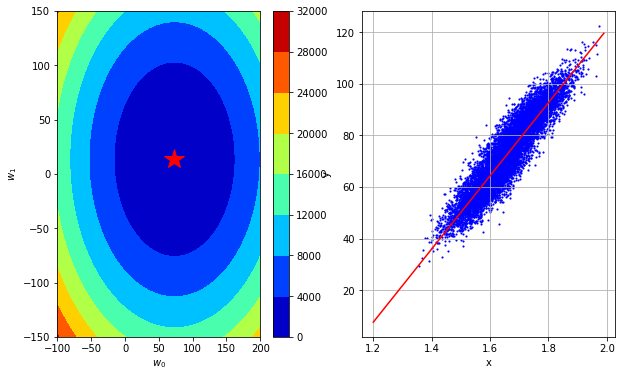

In [8]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=100)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

### Comments:

- the finner the grid, the more precise the solution. However, computational time increases very rapidly without a large improvement in the error: between a grid of size 10 and a 100, we remark that the error is divided by 20 while the time is multiplied by 120.

| Grid size| 10| 100 | 1000 |
| --- | --- | --- |
| Time |0.12 |0.56s   | 60s|
| Precision |27 |0.17    | 0.007|


- in higher dimension, the complexity would increse even more, and this method cannnot be used.

# Gradient Descent

Let's start with a function to compute gradients:

In [9]:
def compute_gradient(y, tx, w):
    """Computes the gradient."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

In [10]:
compute_gradient(y,tx, [0,0])

(array([-73.293922  , -13.47971243]),
 array([109.81967768,  73.68895452,  96.58434842, ...,  58.32779473,
         74.38901745,  51.59669261]))

In [11]:
tx

array([[ 1.        ,  1.94406149],
       [ 1.        ,  0.62753668],
       [ 1.        ,  2.01244346],
       ...,
       [ 1.        , -0.64968792],
       [ 1.        ,  0.69312469],
       [ 1.        , -1.14970831]])

Let's now build our simple gradient descent function:

In [12]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute loss, gradient
        grad, err = compute_gradient(y, tx, w)
        loss = calculate_mse(err)-loss_at_opt
        # gradient w by descent update
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

We test our gradient descent function with the gradient descent demo below:

In [ ]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Definition the parameters of the algorithm.
max_iters = 50
gamma = 0.5

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

In [14]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure>

**Evolution of the excess loss as a function of the number of iterations**

Text(0, 0.5, 'log(L(w)-L(w^*))')

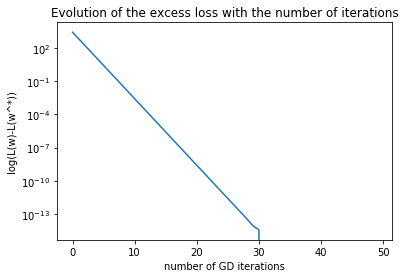

In [15]:
plt.semilogy(gradient_losses)
plt.title('Evolution of the excess loss with the number of iterations')
plt.xlabel('number of GD iterations')
plt.ylabel('log(L(w)-L(w^*))')

We can make the following remarks:
- the excess loss decays at an exponential rate, as predicted by theory:
$$L(w_t)-L(w^*) \le \frac{L}{2} \left(1-\gamma {\mu}\right)^t ||w_0-w^*||^2$$

- an exponential rate means that the error is **squared** when we double the number of iterations. Here for example, the excess loss is 0.0163 after 5 iterations, 9.68e-08 after 10 iterations, 3.55e-15 after 20 iterations


- in semi-log scale, we expect to have a **linear function**: this is what we observe on the graph above
$$\log\left(L(w_t)-L(w^*)\right) \le C -\gamma\mu t $$

- the slope of the line should be $\gamma \mu$. On the graph above, we can check that the log excess loss, decays from $10^2$ to  $ 10^{-14}$ in 30 iterations, (slope -16/30) with a step size 0.5, and $\mu=1$. The theoretical rate is verified.


**Maximum step size**:
- as predicted by theory, there exists a maximum step size: if the step size is larger than $2/L$, the GD algo diverges very quickly.

- Here, the smoothness of the function is 1, thus the maximal step size is 2: the Hessian matrix $tx.T \times   tx$ is identity (because the data has been standardised and we have only 2 dimensions).

- We can also notice that for a step size of 2, the error is constant: indeed, the algorithm oscillates between 2 models, that have the same loss.

# Stochastic gradient descent

In [16]:
def compute_stoch_gradient(y, tx, w):
    """Computes a stochastic gradient from just few examples n and their corresponding y_n labels."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err

def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    wave = initial_w
    
    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            grad, _ = compute_stoch_gradient(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            #w = w - gamma * grad
            w = w - gamma/np.sqrt(n_iter+1) * grad # DECAYING STEPS 
            
            wave = n_iter/(n_iter+1)*wave+ 1/(n_iter+1)*w
            
            # calculate loss
            loss = compute_loss(y, tx, wave)-loss_at_opt
            # store w and loss
            ws.append(w)
            losses.append(loss)

        print("SGD({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [ ]:
# from stochastic_gradient_descent import *

# Definition of the parameters of the algorithm
max_iters = 10000
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

In [18]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

A Jupyter Widget

<function __main__.plot_figure>

**Comments on the algorithm:**
- in order to improve convergence, we use decaying steps, $\gamma_k\varpropto 1/\sqrt{k}$. using small step size reduces the impactof the noise in the gradients.


- moreover, we  compute the loss at the **averaged iterate**: $$\bar w_t= \frac{1}{t} \sum_{i=1}^t w_i$$

- this reduces the effect of noise and improves convergence

- this averaged point can be computed online: $$\bar w_t= \frac{t-1}{t} \bar w_{t-1} +\frac{1}{t} w_t$$



**Comments on the convergence of the algorithm:**
    
- the convergence is much slower that GD in terms of number of iterations, but each iteration only uses 1 observation, while GD uses the 10 000 observations at each step. 
    
- in other words, the complexity of 1 step of GD is the same as the complexity of 10 000 steps of SGD

- for a step size of 1, the loss is 0.003 after 10000 iterations (one epoch), while it is 600 after 1 GD step (also one pass on all gradients)



## Conclusion

**SGD converges much faster that GD if we want a low precision**

**However, GD will reach a high precision (e.g., $10^{-15}$) faster than SGD**

**We do not really care too much about very high precision: the empirical risk minimization problem that GD is solving is itself only an approximation of the unknown (true) generalization risk related to our problem. SGD is thus the algorithm of choice.**